In [1]:
import cv2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.spatial import distance
from skimage import feature, filters, io, morphology, measure, color, draw,transform, util

In [4]:
def get_peas(img,fig_name = None):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    io.imshow(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eroded = morphology.erosion(gray, morphology.disk(2))
    
    #recomended threshold
    high_thresh, thresh_im = cv2.threshold(eroded, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    low_thresh = 0.5*high_thresh

    print("High threshold -> {}, Low threshold -> {}".format(high_thresh, low_thresh))
    
    canny_detector = feature.canny(eroded, sigma=5, low_threshold=10, high_threshold=40)
    
    edges = canny_detector
    diameter_x = 35
    diameter_y = 40
    num_peaks = 150
    # Detect two radii
    hough_radii = np.arange(diameter_x,diameter_y, 1)
    hough_res = transform.hough_circle(edges, hough_radii)
    
    points_x,points_y, radius_c = [],[],[]

    # Select the most prominent 3 circles
    accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,total_num_peaks = num_peaks)

    # Draw them
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = color.gray2rgb(gray)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = draw.circle_perimeter(center_y, center_x, radius, shape=image.shape)
        image[circy, circx] = (255, 0, 0)
        points_x.append(center_x)
        points_y.append(center_y)
        radius_c.append(radius)

    ax.imshow(image, cmap=plt.cm.gray)
    plt.show()
    
    
    #Information about data
    print("Center_x > {}, Center_y > {}, radius > {}".format(center_x,center_y,radius))
    
    x_start = 0 if (center_x - radius) < 0 else center_x - radius
    x_end = center_x + radius
    y_start = 0 if (center_y - radius) < 0 else center_y - radius 
    y_end = center_y + radius
    
    #num of peas
    df = pd.DataFrame(list(zip(points_x, points_y,radius_c)),columns=['x','y','radius'])
    df = df.drop_duplicates(subset = ["x"],keep='last')
    
    try:
        df.sort_values(by = ["x"])
        value = 1
        for i in range(0, 1):
            df = df.reset_index(drop=True)
            indexNames = df[ (df['x'] > df['x'][i] ) & (df['x'] > df['x'][i]+ df['radius'][i]) ].index
            df.drop(indexNames , inplace=True)
            df.reindex()
            value = len(df)
            df.sort_values(by = ["x"])
    except:
        print("Out of bound")
    
    print("Peas = {}".format(len(df)))
    
    
    df = df.reset_index(drop=True)

    return df['x'], df['y'],df['radius']
    

High threshold -> 136.0, Low threshold -> 68.0


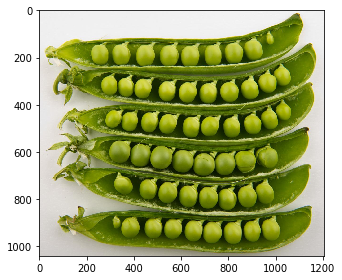

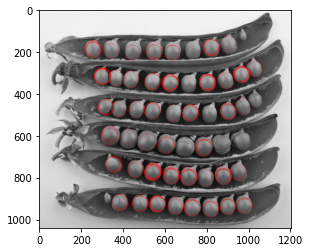

Center_x > 893, Center_y > 334, radius > 39
Peas = 50


In [5]:
peas = get_peas("1.jpg")